In [1]:
import pandas as pd
from tqdm import tqdm
from collections import Counter

from typing import List, Tuple, Callable

from string import punctuation
from nltk import word_tokenize

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Input, Embedding, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Lambda, Concatenate

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 1000)

punctuation += '«»—…“”*№–'

%matplotlib inline

# Data preparation
We will create two version of our data to train and validate the models on: one with very basic preprocessing and one with some more advanced techniques. Then, we will compare the two approaches.

In [2]:
data = pd.read_csv('quora.csv')
data

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a computer science undergrad other than c and c++?,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present?,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on biochemistry at UG level?,0


We are dealing with class imbalance in our dataset. To account for it, let's use class weighting.

In [3]:
class_counts = Counter(data.target)
class_counts

Counter({0: 1225312, 1: 80810})

In [4]:
class_weight = {
    0: 1.,
    1: min(3.,  class_counts[0] / class_counts[1])
}

class_weight

{0: 1.0, 1: 3.0}

In [5]:
def preprocess(text: str) -> List[str]:
    tokens = text.split()
    tokens = [token.strip(punctuation) for token in tokens]
    
    return [char for char in ' '.join([token for token in tokens if token])]

In [6]:
def advanced_preprocessing(text: str) -> List[str]:
    """
    1. Use NLTK word_tokenize function.
    2. Use lowercasing.
    3. Use special tokens (not splitted into chars) for digits.
    """
    tokens = word_tokenize(text.lower())
    tokens = [token.strip(punctuation) for token in tokens]
    
    output = []
    for token in tokens:
        if not token:
            continue
        
        if output:
            # We shouldn't append a space before the first token.
            output.append(' ')
        
        if token.isdigit():
            output.append('<DIGIT>')
            continue
        
        output.extend(token)
    
    return output

In [7]:
def vectorize_data(data: pd.Series, preprocess_fn: Callable = preprocess, min_count: int = 200) -> Tuple[tf.Tensor, int, int]:
    preprocessed = [preprocess_fn(text) for text in tqdm(data)]
    
    vocab = Counter()
    for tokens in preprocessed:
        vocab.update(tokens)
    filtered_vocab = {word for word, count in vocab.items() if count >= min_count}
    
    word2id = {'<PAD>': 0, '<UNK>': 1}
    for word in filtered_vocab:
        word2id[word] = len(word2id)
        
    X = []
    for tokens in preprocessed:
        ids = [word2id.get(token, 1) for token in tokens]
        X.append(ids)
        
    max_len = max(len(tokens) for tokens in preprocessed)
    X = pad_sequences(X, maxlen=max_len)
    
    return X, len(word2id), max_len

In [8]:
X, VOCAB_LEN, MAX_LEN = vectorize_data(data.question_text)
X.shape

100%|██████████| 1306122/1306122 [00:21<00:00, 62087.86it/s]


(1306122, 955)

In [9]:
y = data.target.values
y.shape

(1306122,)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.05, stratify=y, random_state=42
)

# Classification Model

In [11]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
def build_model(
    input_dim: int = VOCAB_LEN,
    max_len: int = MAX_LEN,
    embedding_dim: int = 32,
    hidden_dim: int = 48,
    dropout_rate: float = 0.1,
    l2_rate: float = 1e-4,
    output_dim: int = 1,
    lr: float = 1e-2
):
    inputs = Input(shape=(max_len,))
    embeddings = Embedding(input_dim=input_dim, output_dim=embedding_dim)(inputs)
    embeddings = Dropout(dropout_rate)(embeddings)
    embeddings = Lambda(lambda x: tf.pad(x, [[0, 0], [1, 1], [0, 0]], mode='REFLECT'))(embeddings)
    
    pooling_outputs = []
    for kernel_size in (3, 4, 5):
        conv1 = Conv1D(kernel_size=kernel_size, filters=64, strides=1, kernel_regularizer=regularizers.l2(l2_rate))(embeddings)
        conv1 = Dropout(dropout_rate)(conv1)
        conv1 = Lambda(lambda x: tf.pad(x, [[0, 0], [1, 1], [0, 0]], mode='REFLECT'))(conv1)
        conv2 = Conv1D(kernel_size=kernel_size, filters=64, strides=1, kernel_regularizer=regularizers.l2(l2_rate), activation='relu')(conv1)
        pool = GlobalMaxPooling1D()(conv2)
        
        pooling_outputs.append(pool)
        
    aggregated_pool = Concatenate()(pooling_outputs)
    aggregated_pool = Dropout(dropout_rate)(aggregated_pool)
    hidden = Dense(hidden_dim, activation='relu', kernel_regularizer=regularizers.l2(l2_rate))(aggregated_pool)
    hidden = Dropout(dropout_rate)(hidden)
    
    activation = 'sigmoid' if output_dim == 1 else 'softmax'
    outputs = Dense(output_dim, activation=activation, kernel_regularizer=regularizers.l2(l2_rate))(hidden)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=lr)
    loss = 'binary_crossentropy' if output_dim == 1 else 'categorical_crossentropy'
    
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy', f1])
    
    return model

In [13]:
checkpoint = ModelCheckpoint('model.weights',
                             monitor='val_f1',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True,
                             mode='max',
                             save_freq='epoch'
                            )

early_stopping = EarlyStopping(monitor='val_f1', 
                               min_delta=0.01,
                               patience=3,
                               verbose=1, 
                               mode='max'
                              )


# This scheduler halves the learning rate every two epochs.
# I chose to use a high learning rate at first because of the large batch size.
def scheduler(epoch: int):
    return max(1e-3, 0.01 * 0.5**(epoch // 2))
    
scheduler = LearningRateScheduler(scheduler)

callbacks = [early_stopping, checkpoint, scheduler]

In [14]:
model = build_model()

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2048,
          epochs=50,
          callbacks=callbacks,
          class_weight=class_weight
         )

Epoch 1/50
606/606 [==============================] - ETA: 0s - loss: 0.3600 - accuracy: 0.9297 - f1: 0.4087
Epoch 00001: val_f1 improved from -inf to 0.55407, saving model to model.weights
606/606 [==============================] - 354s 584ms/step - loss: 0.3600 - accuracy: 0.9297 - f1: 0.4087 - val_loss: 0.2055 - val_accuracy: 0.9373 - val_f1: 0.5541 - lr: 0.0100
Epoch 2/50
606/606 [==============================] - ETA: 0s - loss: 0.3224 - accuracy: 0.9331 - f1: 0.5151
Epoch 00002: val_f1 improved from 0.55407 to 0.56078, saving model to model.weights
606/606 [==============================] - 351s 579ms/step - loss: 0.3224 - accuracy: 0.9331 - f1: 0.5151 - val_loss: 0.2123 - val_accuracy: 0.9337 - val_f1: 0.5608 - lr: 0.0100
Epoch 3/50
606/606 [==============================] - ETA: 0s - loss: 0.3006 - accuracy: 0.9358 - f1: 0.5435
Epoch 00003: val_f1 improved from 0.56078 to 0.57099, saving model to model.weights
606/606 [==============================] - 351s 579ms/step - loss: 0

dict_keys(['loss', 'accuracy', 'f1', 'val_loss', 'val_accuracy', 'val_f1', 'lr'])


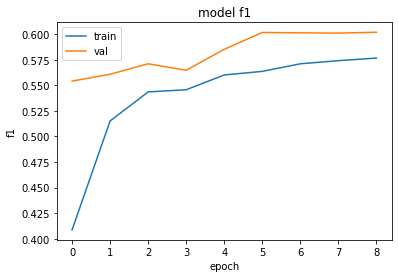

In [15]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Advanced preprocessing

In [14]:
X, VOCAB_LEN, MAX_LEN = vectorize_data(data.question_text, preprocess_fn=advanced_preprocessing)
X.shape

100%|██████████| 1306122/1306122 [06:51<00:00, 3171.67it/s]


(1306122, 754)

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.05, stratify=y, random_state=42
)

In [16]:
checkpoint = ModelCheckpoint('model_v2.weights',
                             monitor='val_f1',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True,
                             mode='max',
                             save_freq='epoch'
                            )

callbacks = [early_stopping, checkpoint, scheduler]

In [17]:
model = build_model(input_dim=VOCAB_LEN, max_len=MAX_LEN)

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2048,
          epochs=50,
          callbacks=callbacks,
          class_weight=class_weight
         )

Epoch 1/50
606/606 [==============================] - ETA: 0s - loss: 0.3748 - accuracy: 0.9289 - f1: 0.3671
Epoch 00001: val_f1 improved from -inf to 0.53394, saving model to model_v2.weights
606/606 [==============================] - 270s 445ms/step - loss: 0.3748 - accuracy: 0.9289 - f1: 0.3671 - val_loss: 0.1866 - val_accuracy: 0.9432 - val_f1: 0.5339 - lr: 0.0100
Epoch 2/50
606/606 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.9330 - f1: 0.5085
Epoch 00002: val_f1 improved from 0.53394 to 0.54331, saving model to model_v2.weights
606/606 [==============================] - 267s 440ms/step - loss: 0.3292 - accuracy: 0.9330 - f1: 0.5085 - val_loss: 0.1762 - val_accuracy: 0.9455 - val_f1: 0.5433 - lr: 0.0100
Epoch 3/50
606/606 [==============================] - ETA: 0s - loss: 0.3059 - accuracy: 0.9354 - f1: 0.5375
Epoch 00003: val_f1 improved from 0.54331 to 0.57978, saving model to model_v2.weights
606/606 [==============================] - 267s 440ms/step 

dict_keys(['loss', 'accuracy', 'f1', 'val_loss', 'val_accuracy', 'val_f1', 'lr'])


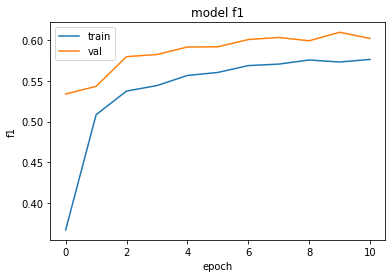

In [18]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Conclusion

In this particular task, the way of preprocessing the data does not matter too much. The advanced preprocessing allowed us to obtain only marginally better results (F1-score: **60.183** vs. **60.974**).